<a href="https://colab.research.google.com/github/kanaka-22/CT_Scan_Detection/blob/main/ct_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Conv2D,Conv3D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing import image
from glob import glob

In [ ]:
IMAGE_SIZE = [224, 224] 

# training config:
epochs = 100
batch_size = 32

In [ ]:
covid_ct='/content/drive/My Drive/SARS-COVID-19 CT SCANS/COVID-CT'
non_covid_ct='/content/drive/My Drive/SARS-COVID-19 CT SCANS/non-COVID-CT'
covid_files = glob(covid_ct + '/*')
non_covid_ct_files = glob(non_covid_ct + '/*')

In [ ]:
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",non_covid_ct_files[0:5])
print("Total Count: ",len(non_covid_ct_files))

First 5 Covid Files:  ['/content/drive/My Drive/SARS-COVID-19 CT SCANS/COVID-CT/Covid (585).png', '/content/drive/My Drive/SARS-COVID-19 CT SCANS/COVID-CT/Covid (582).png', '/content/drive/My Drive/SARS-COVID-19 CT SCANS/COVID-CT/Covid (581).png', '/content/drive/My Drive/SARS-COVID-19 CT SCANS/COVID-CT/Covid (590).png', '/content/drive/My Drive/SARS-COVID-19 CT SCANS/COVID-CT/Covid (593).png']
Total Count:  1252
First 5 NonCovid Files:  ['/content/drive/My Drive/SARS-COVID-19 CT SCANS/non-COVID-CT/Non-Covid (586).png', '/content/drive/My Drive/SARS-COVID-19 CT SCANS/non-COVID-CT/Non-Covid (589).png', '/content/drive/My Drive/SARS-COVID-19 CT SCANS/non-COVID-CT/Non-Covid (582).png', '/content/drive/My Drive/SARS-COVID-19 CT SCANS/non-COVID-CT/Non-Covid (584).png', '/content/drive/My Drive/SARS-COVID-19 CT SCANS/non-COVID-CT/Non-Covid (583).png']
Total Count:  1267


In [ ]:
covid_ct_labels = []
non_covid_ct_labels = []
covid_ct_images=[]
non_covid_ct_images=[]

In [ ]:
for i in range(len(covid_files)):
  import cv2 
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_ct_images.append(image)
  covid_ct_labels.append('COVID_CT')

In [ ]:
for i in range(len(non_covid_ct_files)):
  image = cv2.imread(non_covid_ct_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  non_covid_ct_images.append(image)
  non_covid_ct_labels.append('NonCOVID_CT')

In [ ]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))
    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()
    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1,0.9])
    plt.show()    

<Figure size 432x288 with 0 Axes>

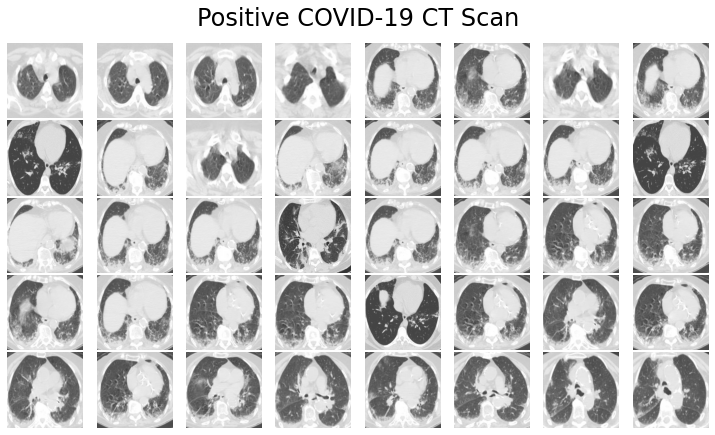

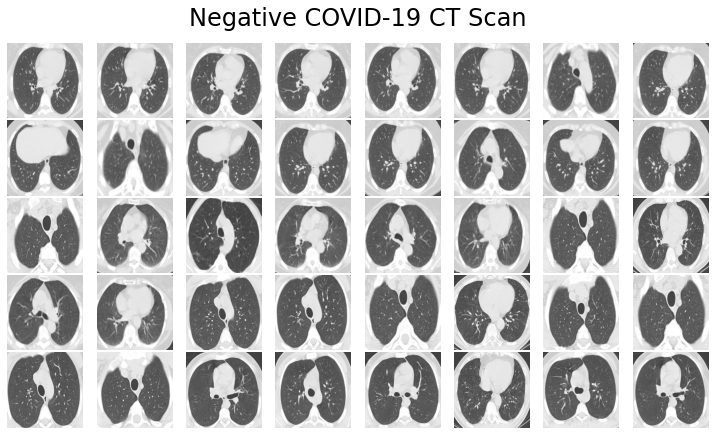

In [ ]:
plt.tight_layout(pad=0.2, rect=[0, 0, 1,0.9])
plt.show()
plot_images(covid_ct_images, 'Positive COVID-19 CT Scan')
plot_images(non_covid_ct_images, 'Negative COVID-19 CT Scan')

In [ ]:
covid_ct_images = np.array(covid_ct_images) / 255
non_covid_ct_images = np.array(non_covid_ct_images) / 255
covid_ct_labels = np.array([1 for _ in range(len(covid_ct_images))])
non_covid_ct_labels = np.array([0 for _ in range(len(non_covid_ct_images))])
from sklearn.model_selection import train_test_split
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(covid_ct_images, covid_ct_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(non_covid_ct_images, non_covid_ct_labels, test_size=0.2)
X_train = np.concatenate((noncovid_x_train[:80], covid_x_train[:80]), axis=0)
X_test = np.concatenate((noncovid_x_test[80:], covid_x_test[80:]), axis=0)
y_train = np.concatenate((noncovid_y_train[:80], covid_y_train[:80]), axis=0)
y_test = np.concatenate((noncovid_y_test[80:], covid_y_test[80:]), axis=0)

In [ ]:
print("Number of samples in train and test are %d and %d.",(X_train.shape[0],X_test.shape[0]))

Number of samples in train and test are %d and %d. (160, 345)


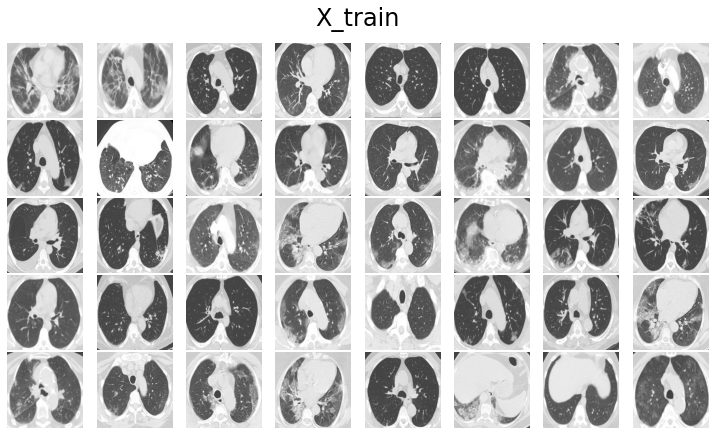

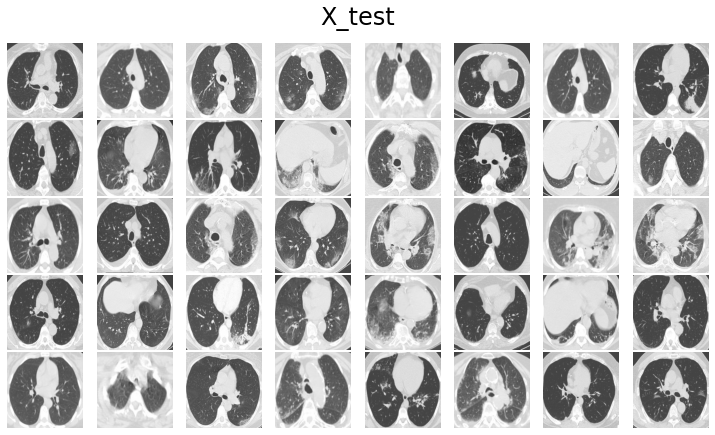

In [ ]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
test_aug = ImageDataGenerator(rescale=1. /255)

In [ ]:
model = tf.keras.models.Sequential([
  
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
  
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       2

In [ ]:
model.compile(loss="binary_crossentropy",optimizer=RMSprop(lr=0.001),metrics=["accuracy"])
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
history = model.fit_generator(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) // batch_size,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
5/5 [==============================] - 29s 6s/step - loss: 5.8716 - accuracy: 0.4750 - val_loss: 2.5924 - val_accuracy: 0.5043
Epoch 2/100
5/5 [==============================] - 29s 6s/step - loss: 0.9870 - accuracy: 0.5625 - val_loss: 0.6998 - val_accuracy: 0.4957
Epoch 3/100
5/5 [==============================] - 28s 6s/step - loss: 0.7000 - accuracy: 0.5000 - val_loss: 0.6915 - val_accuracy: 0.4957
Epoch 4/100
5/5 [==============================] - 28s 6s/step - loss: 0.6950 - accuracy: 0.4750 - val_loss: 0.6912 - val_accuracy: 0.4957
Epoch 5/100
5/5 [==============================] - 28s 6s/step - loss: 0.6941 - accuracy: 0.4875 - val_loss: 0.6906 - val_accuracy: 0.6493
Epoch 6/100
5/5 [==============================] - 28s 6s/step - loss: 0.6918 - accuracy: 0.5188 - val_loss: 0.6943 - val_accuracy: 0.5043
Epoch 7/100
5/5 [==============================] - 29s 6s/step - loss: 0.6912 - accuracy: 

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.5709413886070251
Test accuracy: 0.7014492750167847


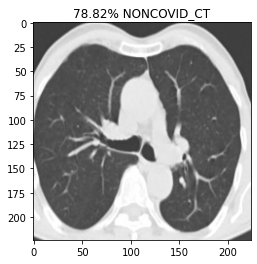

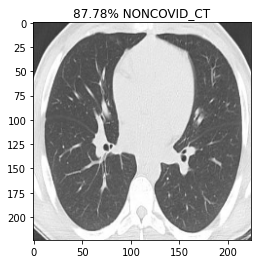

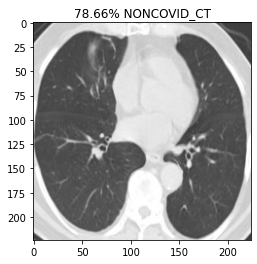

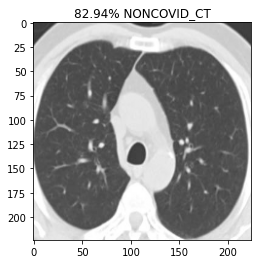

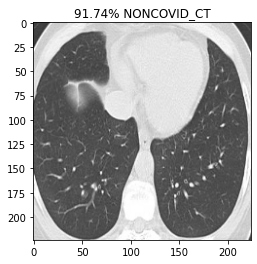

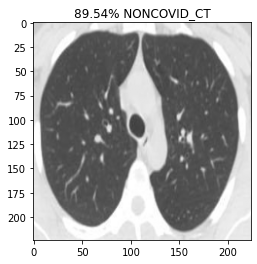

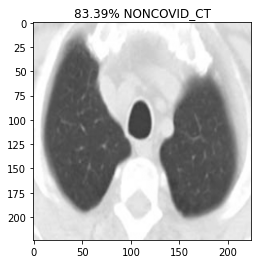

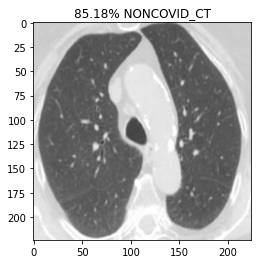

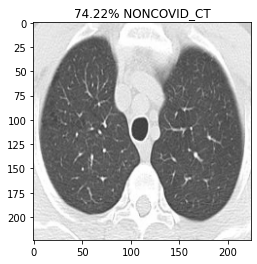

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)
prediction=y_pred[1:10]
for index, probability in enumerate(prediction):
  if probability[0] > 0.5:
     plt.title('%.2f' % (probability[0]*100) + '% COVID_CT')
  else:
    plt.title('%.2f' % ((1-probability[0])*100) + '% NONCOVID_CT')
  plt.imshow(X_test[index])
  plt.show()

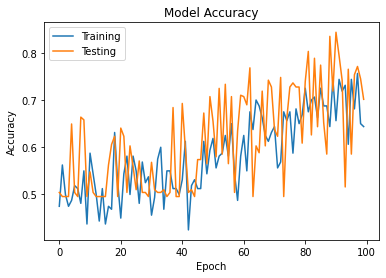

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()

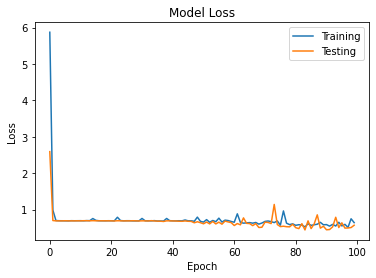

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()